# Load Both Datasets

In [1]:
import json, pandas as pd

def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return pd.DataFrame(json.load(f))

df1 = load_json("train.model-agnostic.json")
df2 = load_json("train.model-aware.v2.json")

df = pd.concat([df1, df2], ignore_index=True)
print("Total rows:", len(df))
print(df.head())

Total rows: 60000
                                  hyp  \
0   Don't worry, it's only temporary.   
1    Tom is never where he should be.   
2  It's hard for me to work with Tom.   
3                      Water, please.   
4   I didn't expect Tom to betray me.   

                                        tgt  \
0         Don't worry. It's only temporary.   
1   Tom is never where he's supposed to be.   
2          I have trouble working with Tom.   
3                      I'd like some water.   
4  I didn't think that Tom would betray me.   

                                         src     ref task model  
0          Не волнуйся. Это только временно.  either   MT        
1  Тома никогда нет там, где он должен быть.  either   MT        
2               Мне сложно работать с Томом.  either   MT        
3                          Воду, пожалуйста.  either   MT        
4         Я не ожидал, что Том предаст меня.  either   MT        


# Normalize Text

In [3]:
import re, unicodedata

def normalize(text):
    if pd.isna(text): return ""
    text = unicodedata.normalize("NFKC", str(text))
    text = re.sub(r"\s+", " ", text)
    return text.strip()

for col in ["src", "hyp", "tgt"]:
    df[col] = df[col].apply(normalize)

# Handle Missing Data

In [4]:
def valid_row(row):
    if not row["hyp"]: return False
    if row["ref"] == "src" and not row["src"]: return False
    if row["ref"] == "tgt" and not row["tgt"]: return False
    if row["ref"] == "either" and (not row["src"] and not row["tgt"]): return False
    return True

df = df[df.apply(valid_row, axis=1)]

# Remove Duplicates

In [5]:
df = df.drop_duplicates(subset=["src", "hyp", "tgt", "ref"])

# Add concatenated input text (for the model)

In [6]:
df["concat_text"] = (
    "Source: " + df["src"] + "\n" +
    "Hypothesis: " + df["hyp"] + "\n" +
    "Target: " + df["tgt"]
)

# Save cleaned dataset

In [7]:
df.to_csv("hallucination_clean.csv", index=False)
print("✅ Clean dataset saved with", len(df), "rows")

✅ Clean dataset saved with 58648 rows


# Work Done in 4Hrs


## Approach 1 (Logistic Regression)

In [8]:
!pip install datasets

In [9]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.6 MB/s eta 0:00:00


### Training Set (Approach 1)

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
import time

In [23]:
df = pd.read_csv("hallucination_clean.csv")

In [24]:
label_map = {"either": 0, "src": 1, "tgt": 1}
df["label"] = df["ref"].map(label_map)
print("Label distribution:\n", df["label"].value_counts())

Label distribution:
 label
1    39999
0    18649
Name: count, dtype: int64


In [25]:
X = df["concat_text"]
y = df["label"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [26]:
print("Split sizes: Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

Split sizes: Train: 41053 Val: 8797 Test: 8798


In [27]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), max_df=0.8)),  # Optimized for speed/accuracy
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, C=1.0))  # Balanced for imbalance
])

In [28]:
start_time = time.time()
pipeline.fit(X_train, y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Training time: 7.42 seconds


In [29]:
y_val_pred = pipeline.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation F1: {val_f1:.4f}")

Validation Accuracy: 0.9812
Validation F1: 0.9861


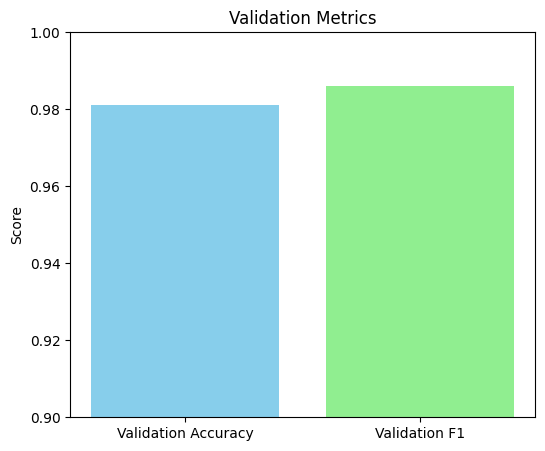

In [43]:
import matplotlib.pyplot as plt

# Metrics
metrics = ["Validation Accuracy", "Validation F1"]
values = [0.9812, 0.9861]  # from your output

# Plot
plt.figure(figsize=(6,5))
plt.bar(metrics, values, color=["skyblue", "lightgreen"])
plt.ylim(0.9, 1.0)  # zoom in for better visualization
plt.title("Validation Metrics")
plt.ylabel("Score")
plt.show()


In [30]:
y_test_pred = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1: {test_f1:.4f}")

Test Accuracy: 0.9789
Test F1: 0.9844


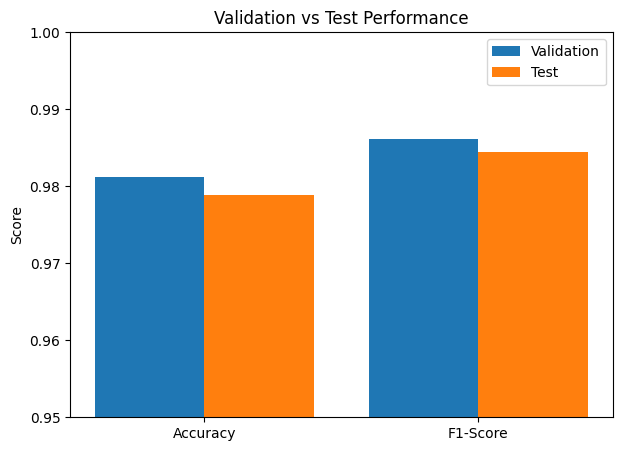

In [44]:
import matplotlib.pyplot as plt

# Metrics
metrics = ["Accuracy", "F1-Score"]
validation_scores = [0.9812, 0.9861]
test_scores = [0.9789, 0.9844]

x = range(len(metrics))

plt.figure(figsize=(7,5))
plt.bar([p - 0.2 for p in x], validation_scores, width=0.4, label="Validation")
plt.bar([p + 0.2 for p in x], test_scores, width=0.4, label="Test")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0.95, 1.0)
plt.title("Validation vs Test Performance")
plt.legend()
plt.show()


In [31]:
import joblib
joblib.dump(pipeline, "hallucination_detector_fast.pkl")
print("Model saved to hallucination_detector_fast.pkl")

Model saved to hallucination_detector_fast.pkl


### Testing Set (Approach 1)

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import joblib
import difflib
import warnings

In [33]:
warnings.filterwarnings("ignore", category=SyntaxWarning)

In [34]:
df = pd.read_csv("hallucination_clean.csv")

In [35]:
label_map = {"either": 0, "src": 1, "tgt": 1}
df["label"] = df["ref"].map(label_map)
print("Label distribution in full dataset:\n", df["label"].value_counts())

Label distribution in full dataset:
 label
1    39999
0    18649
Name: count, dtype: int64


In [36]:
print("\nNaN counts in dataset:")
print(df[["src", "hyp", "tgt", "concat_text"]].isna().sum())


NaN counts in dataset:
src                0
hyp                0
tgt            19999
concat_text        0
dtype: int64


In [37]:
X = df["concat_text"]
y = df["label"]
_, X_temp, _, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_test, _, y_test, _ = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print("Test set size:", len(X_test))

Test set size: 8797


In [38]:
try:
    pipeline = joblib.load("hallucination_detector_fast.pkl")
    print("Loaded Logistic Regression model from hallucination_detector_fast.pkl")
except FileNotFoundError:
    print("ERROR: Model file 'hallucination_detector_fast.pkl' not found. Please train the model first.")
    exit()

Loaded Logistic Regression model from hallucination_detector_fast.pkl


In [39]:
start_time = time.time()
y_test_pred = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
end_time = time.time()
print(f"\nTest Set Evaluation Results:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Evaluation time: {end_time - start_time:.2f} seconds")


Test Set Evaluation Results:
Test Accuracy: 0.9812
Test F1 Score: 0.9861
Evaluation time: 2.12 seconds



Confusion Matrix (rows: true, cols: predicted):
 [[2762   35]
 [ 130 5870]]


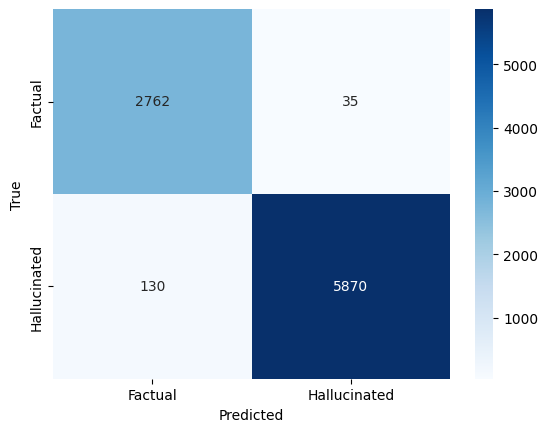

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (rows: true, cols: predicted):\n", cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Factual", "Hallucinated"], yticklabels=["Factual", "Hallucinated"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [42]:
import json
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import warnings

In [43]:
# Function to predict hallucination with adjustable threshold
def predict_hallucination(src, hyp, tgt, threshold=0.5):
    concat_text = f"Source: {src}\nHypothesis: {hyp}\nTarget: {tgt if pd.notna(tgt) else ''}"
    prob = pipeline.predict_proba([concat_text])[0][1]  # Probability of hallucination (label 1)
    label = 1 if prob >= threshold else 0
    return {"label": label, "hallucination_probability": prob, "threshold": threshold}

### Test Dataset Given (Approach 1)

In [44]:
# Load and process test.model-agnostic.json
with open("test.model-agnostic.json", "r") as f:
    agnostic_data = json.load(f)

# Load and process test.model-aware.json
with open("test.model-aware.json", "r") as f:
    aware_data = json.load(f)

In [45]:
# Combine data
test_data = agnostic_data + aware_data
print(f"Total test samples: {len(test_data)}")

Total test samples: 3000


In [46]:
predictions = []
true_labels = []
for item in test_data:
    src = item["src"]
    hyp = item["hyp"]
    tgt = item["tgt"] if item["tgt"] else ""  # Handle empty tgt
    true_label = 1 if item["label"] == "Hallucination" else 0
    pred = predict_hallucination(src, hyp, tgt, threshold=0.5)
    predictions.append(pred["label"])
    true_labels.append(true_label)
    print(f"\nID: {item['id']}, Task: {item['task']}")
    print(f"Src: {src}")
    print(f"Hyp: {hyp}")
    print(f"Tgt: {tgt}")
    print(f"True Label: {'Hallucination' if true_label == 1 else 'Not Hallucination'} (p={item['p(Hallucination)']})")
    print(f"Predicted Label: {'Hallucination' if pred['label'] == 1 else 'Not Hallucination'} (Prob: {pred['hallucination_probability']:.4f})")


Streaming output truncated to the last 5000 lines.
True Label: Hallucination (p=0.8)
Predicted Label: Not Hallucination (Prob: 0.1802)

ID: 1613, Task: PG
Src: The 1997 Daphne programme was heavily oversubscribed with less than 10 % of applications receiving funding.
Hyp: Less than 10 percent of applications received funding in the 1997 programme.
Tgt: 
True Label: Hallucination (p=0.6)
Predicted Label: Hallucination (Prob: 0.8413)

ID: 1615, Task: PG
Src: The Danube in my view must become a symbol of our unity rather than a blocked artery in the body of Europe.
Hyp: The body of Europe needs to become a symbol of unity instead of a blocked arteries.
Tgt: 
True Label: Hallucination (p=1.0)
Predicted Label: Hallucination (Prob: 0.9067)

ID: 1618, Task: PG
Src: Women are falling victim to war criminals because they are women, and the EU must recognise this as grounds for asylum.
Hyp: The EU must recognize that war criminals are falling victim to women because they are females.
Tgt: 
True 

In [47]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)

print(f"\nEvaluation Metrics (Threshold 0.5):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")


Evaluation Metrics (Threshold 0.5):
Accuracy: 0.4763
Precision: 0.3791
Recall: 0.5516
F1 Score: 0.4494
Confusion Matrix:
[[ 788 1050]
 [ 521  641]]


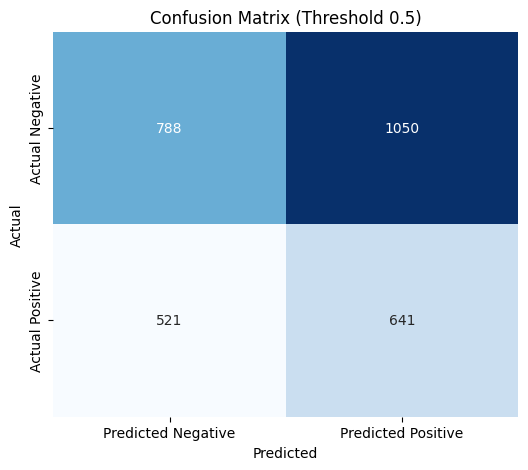

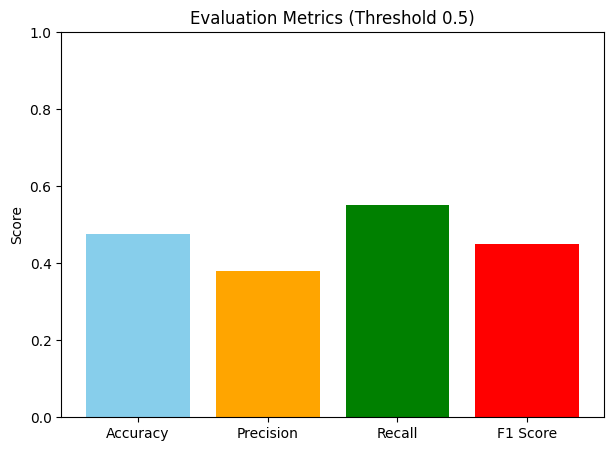

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Provided metrics
accuracy = 0.4763
precision = 0.3791
recall = 0.5516
f1 = 0.4494
conf_matrix = np.array([[788, 1050],
                        [521, 641]])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix (Threshold 0.5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot bar chart for metrics
metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
plt.figure(figsize=(7, 5))
plt.bar(metrics.keys(), metrics.values(), color=["skyblue", "orange", "green", "red"])
plt.ylim(0, 1)
plt.title("Evaluation Metrics (Threshold 0.5)")
plt.ylabel("Score")
plt.show()


In [48]:
# Test with adjusted threshold (0.4) based on previous findings
predictions_04 = [1 if predict_hallucination(item["src"], item["hyp"], item["tgt"], threshold=0.4)["label"] == 1 else 0 for item in test_data]
accuracy_04 = accuracy_score(true_labels, predictions_04)
f1_04 = f1_score(true_labels, predictions_04)
conf_matrix_04 = confusion_matrix(true_labels, predictions_04)

print(f"\nEvaluation Metrics (Threshold 0.4):")
print(f"Accuracy: {accuracy_04:.4f}")
print(f"F1 Score: {f1_04:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_04}")


Evaluation Metrics (Threshold 0.4):
Accuracy: 0.4777
F1 Score: 0.4694
Confusion Matrix:
[[ 740 1098]
 [ 469  693]]


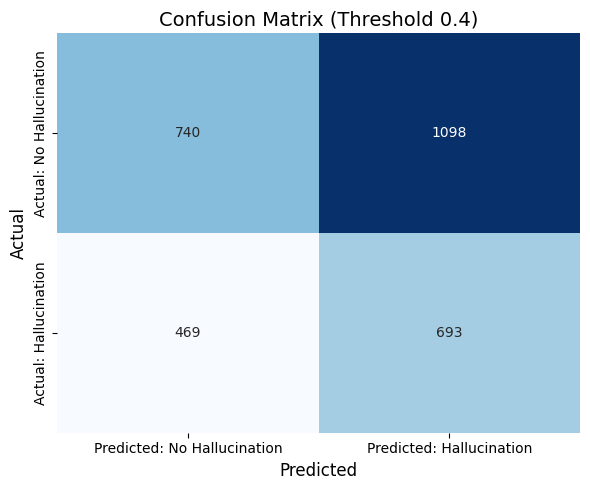

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix values
conf_matrix_04 = [[740, 1098],
                  [469, 693]]

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_04, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted: No Hallucination", "Predicted: Hallucination"],
            yticklabels=["Actual: No Hallucination", "Actual: Hallucination"])
plt.title("Confusion Matrix (Threshold 0.4)", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()


# Next 18Hrs

## Approach 2 (Recurrent Neural Networks)

In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings

In [3]:
warnings.filterwarnings("ignore", category=SyntaxWarning)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
torch.cuda.empty_cache()  # Clear GPU memory
print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA available: True
GPU Name: Tesla T4


In [7]:
data = pd.read_csv("/content/hallucination_clean.csv").sample(5000, random_state=42)
data['tgt'] = data['tgt'].fillna("")  # Handle missing targets


In [8]:
print("Available columns:", data.columns)

Available columns: Index(['hyp', 'tgt', 'src', 'ref', 'task', 'model', 'concat_text'], dtype='object')


In [9]:
# Apply label mapping based on 'ref' column
label_map = {"either": 0, "src": 1, "tgt": 1}  # Match your old model
if 'ref' not in data.columns:
    raise KeyError("Column 'ref' not found. Available columns: " + str(data.columns))
labels_series = data['ref'].map(label_map)  # Map first
labels = labels_series.fillna(0).astype(int).values  # Handle unmapped values, then convert to NumPy


In [10]:
texts = [f"Source: {src}\nHypothesis: {hyp}\nTarget: {tgt}" for src, hyp, tgt in zip(data['src'], data['hyp'], data['tgt'])]


## Training Set (Approach 2)

In [11]:
# Split data (70% train, 15% val, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [12]:
print("Loading multilingual transformer...")
embed_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device=device)  # Explicitly set device
print("Generating embeddings...")
X_train_embed = embed_model.encode(X_train, show_progress_bar=True, batch_size=64, device=device)
X_val_embed = embed_model.encode(X_val, show_progress_bar=True, batch_size=64, device=device)
X_test_embed = embed_model.encode(X_test, show_progress_bar=True, batch_size=64, device=device)


Loading multilingual transformer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings...


Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [13]:
class HallucinationDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [14]:
# Create DataLoaders
train_dataset = HallucinationDataset(X_train_embed, y_train)
val_dataset = HallucinationDataset(X_val_embed, y_val)
test_dataset = HallucinationDataset(X_test_embed, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [15]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])


In [16]:
input_dim = X_train_embed.shape[1]
hidden_dim = 64
output_dim = 2
lstm_model = LSTMClassifier(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.5]).to(device))
optimizer = optim.Adam(lstm_model.parameters(), lr=0.01)

In [22]:
#Train the Model
print("Training LSTM model...")
num_epochs = 100  # Max 100 epochs
for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0
    for embeddings, labels in train_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Training LSTM model...
Epoch 1/100, Loss: 0.0000
Epoch 2/100, Loss: 0.0000
Epoch 3/100, Loss: 0.0000
Epoch 4/100, Loss: 0.0000
Epoch 5/100, Loss: 0.0000
Epoch 6/100, Loss: 0.0000
Epoch 7/100, Loss: 0.0000
Epoch 8/100, Loss: 0.0000
Epoch 9/100, Loss: 0.0000
Epoch 10/100, Loss: 0.0000
Epoch 11/100, Loss: 0.0000
Epoch 12/100, Loss: 0.0000
Epoch 13/100, Loss: 0.0000
Epoch 14/100, Loss: 0.0000
Epoch 15/100, Loss: 0.0000
Epoch 16/100, Loss: 0.0000
Epoch 17/100, Loss: 0.0000
Epoch 18/100, Loss: 0.0000
Epoch 19/100, Loss: 0.0000
Epoch 20/100, Loss: 0.0000
Epoch 21/100, Loss: 0.0000
Epoch 22/100, Loss: 0.0000
Epoch 23/100, Loss: 0.0000
Epoch 24/100, Loss: 0.0000
Epoch 25/100, Loss: 0.0000
Epoch 26/100, Loss: 0.0000
Epoch 27/100, Loss: 0.0000
Epoch 28/100, Loss: 0.0000
Epoch 29/100, Loss: 0.0000
Epoch 30/100, Loss: 0.0000
Epoch 31/100, Loss: 0.0000
Epoch 32/100, Loss: 0.0000
Epoch 33/100, Loss: 0.0000
Epoch 34/100, Loss: 0.0000
Epoch 35/100, Loss: 0.0000
Epoch 36/100, Loss: 0.0000
Epoch 37/100, 

In [23]:
#Evaluate on Test Set
lstm_model.eval()
y_test_pred = []
with torch.no_grad():
    for embeddings, _ in test_loader:
        embeddings = embeddings.to(device)
        outputs = lstm_model(embeddings)
        y_test_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1: {test_f1:.4f}")

Test Accuracy: 0.9667
Test F1: 0.9756



Confusion Matrix (rows: true, cols: predicted):
 [[225  18]
 [  7 500]]


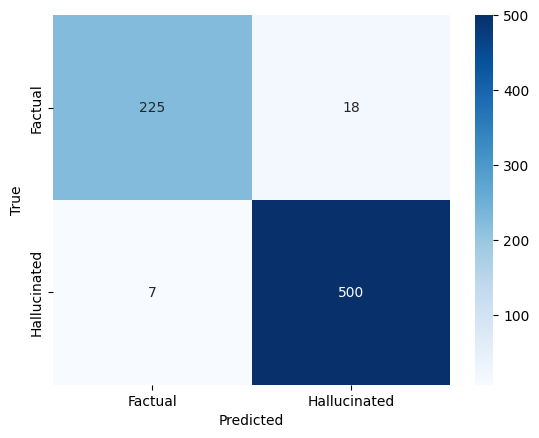

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (rows: true, cols: predicted):\n", cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Factual", "Hallucinated"], yticklabels=["Factual", "Hallucinated"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [24]:
# Save the Model
torch.save(lstm_model.state_dict(), "hallucination_detector_lstm_fast.pth")
print("Saved LSTM model as hallucination_detector_lstm_fast.pth")

Saved LSTM model as hallucination_detector_lstm_fast.pth


## Test Dataset Given (Approach 2)

In [26]:
import json
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import warnings

In [27]:
warnings.filterwarnings("ignore", category=SyntaxWarning)

In [28]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

In [29]:
# Load model state
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
input_dim = 384
hidden_dim = 64
output_dim = 2
lstm_model = LSTMClassifier(input_dim, hidden_dim, output_dim).to(device)
lstm_model.load_state_dict(torch.load("hallucination_detector_lstm_fast.pth"))
lstm_model.eval()
print("Loaded LSTM model from hallucination_detector_lstm_fast.pth")

Using device: cuda
Loaded LSTM model from hallucination_detector_lstm_fast.pth


In [30]:
# Load multilingual transformer
embed_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device=device)

In [31]:
# Function to predict hallucination with LSTM
def predict_hallucination(src, hyp, tgt="", threshold=0.5):
    concat_text = f"Source: {src}\nHypothesis: {hyp}\nTarget: {tgt if tgt else ''}"
    embed = embed_model.encode([concat_text], batch_size=64, device=device)
    embed = torch.tensor(embed, dtype=torch.float32).to(device)
    with torch.no_grad():
        output = lstm_model(embed)
        prob = torch.softmax(output, dim=1)[0][1].item()  # Probability of hallucination (class 1)
        label = 1 if prob >= threshold else 0
    return {"label": label, "hallucination_probability": prob, "threshold": threshold}

In [32]:
# Load test data
with open("/content/test.model-agnostic.json", "r") as f:
    agnostic_data = json.load(f)
with open("/content/test.model-aware.json", "r") as f:
    aware_data = json.load(f)
test_data = agnostic_data + aware_data
print(f"Total test samples: {len(test_data)}")

Total test samples: 3000


In [33]:
# label mapping
label_map = {"either": 0, "src": 1, "tgt": 1}  # Match your old model
true_labels = []
predictions = []
for item in test_data:
    src = item["src"]
    hyp = item["hyp"]
    tgt = item["tgt"] if item.get("tgt") else ""
    true_label = label_map.get(item["label"].lower(), 0)  # Map labels
    pred = predict_hallucination(src, hyp, tgt, threshold=0.5)
    true_labels.append(true_label)
    predictions.append(pred["label"])
    print(f"\nID: {item['id']}, Task: {item['task']}")
    print(f"Src: {src}")
    print(f"Hyp: {hyp}")
    print(f"Tgt: {tgt}")
    print(f"True Label: {'Hallucination' if true_label == 1 else 'Not Hallucination'} (p={item.get('p(Hallucination)', 'N/A')})")
    print(f"Predicted Label: {'Hallucination' if pred['label'] == 1 else 'Not Hallucination'} (Prob: {pred['hallucination_probability']:.4f})")


Streaming output truncated to the last 5000 lines.
True Label: Not Hallucination (p=0.8)
Predicted Label: Not Hallucination (Prob: 0.0000)

ID: 1613, Task: PG
Src: The 1997 Daphne programme was heavily oversubscribed with less than 10 % of applications receiving funding.
Hyp: Less than 10 percent of applications received funding in the 1997 programme.
Tgt: 
True Label: Not Hallucination (p=0.6)
Predicted Label: Hallucination (Prob: 1.0000)

ID: 1615, Task: PG
Src: The Danube in my view must become a symbol of our unity rather than a blocked artery in the body of Europe.
Hyp: The body of Europe needs to become a symbol of unity instead of a blocked arteries.
Tgt: 
True Label: Not Hallucination (p=1.0)
Predicted Label: Hallucination (Prob: 1.0000)

ID: 1618, Task: PG
Src: Women are falling victim to war criminals because they are women, and the EU must recognise this as grounds for asylum.
Hyp: The EU must recognize that war criminals are falling victim to women because they are females.

In [34]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)

print(f"\nEvaluation Metrics (Threshold 0.5):")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")


Evaluation Metrics (Threshold 0.5):
Accuracy: 0.4160
F1 Score: 0.0000
Confusion Matrix:
[[1248 1752]
 [   0    0]]


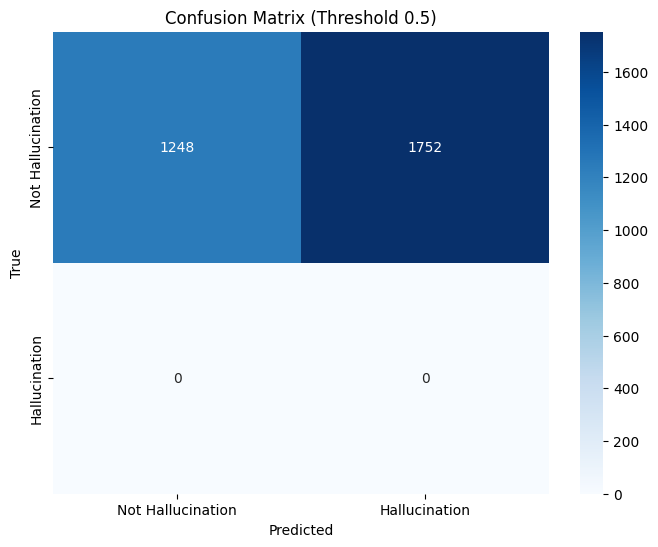

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Confusion Matrix Heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Hallucination", "Hallucination"],
            yticklabels=["Not Hallucination", "Hallucination"])
plt.title("Confusion Matrix (Threshold 0.5)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


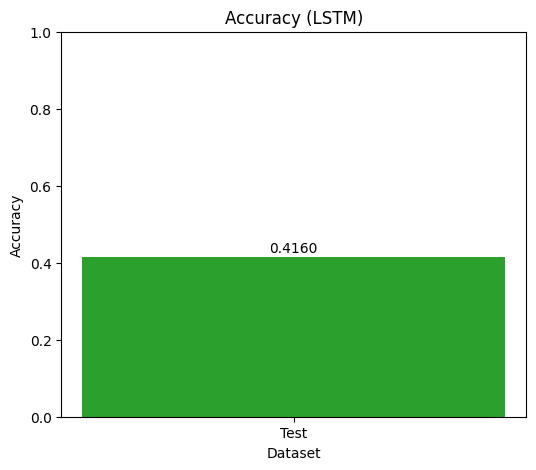

In [41]:
datasets = ["Test"]
accuracies = [accuracy]

plt.figure(figsize=(6, 5))
plt.bar(datasets, accuracies, color=['#2ca02c'])
plt.title("Accuracy (LSTM)")
plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# Add value on bar
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha="center")

plt.show()

# Approach 3 (Logistic Regression)

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
import joblib

In [49]:
df = pd.read_csv("hallucination_clean.csv")

In [50]:
label_map = {"either": 0, "src": 1, "tgt": 1}
df["label"] = df["ref"].map(label_map)

In [52]:
df["tgt"] = df["tgt"].fillna("")
df["concat_text"] = "Source: " + df["src"] + "\nHypothesis: " + df["hyp"] + "\nTarget: " + df["tgt"]

In [53]:
X = df["concat_text"]
y = df["label"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [54]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(2, 5), max_features=10000, max_df=0.8)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, C=1.0))
])

In [55]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_df=0.8,
                                 max_features=10000, ngram_range=(2, 5))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [56]:
y_val_pred = pipeline.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation F1: {val_f1:.4f}")

Validation Accuracy: 0.9975
Validation F1: 0.9982


In [57]:
y_test_pred = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1: {test_f1:.4f}")

Test Accuracy: 0.9970
Test F1: 0.9978


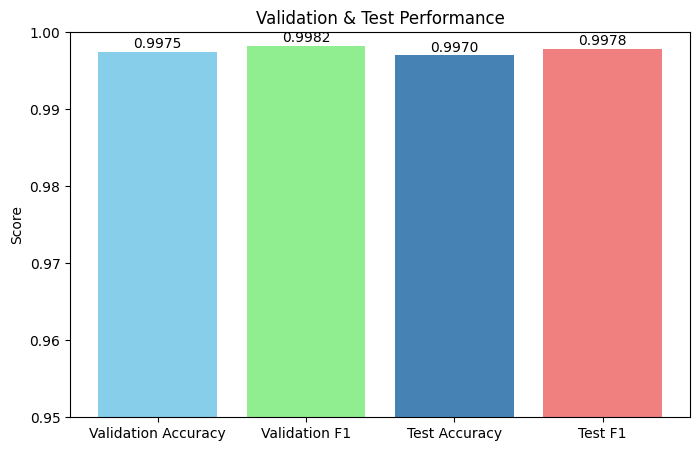

In [60]:
import matplotlib.pyplot as plt

# Your values
metrics = ["Validation Accuracy", "Validation F1", "Test Accuracy", "Test F1"]
scores = [0.9975, 0.9982, 0.9970, 0.9978]

# Plot
plt.figure(figsize=(8,5))
plt.bar(metrics, scores, color=["skyblue","lightgreen","steelblue","lightcoral"])
plt.ylim(0.95, 1.0)
plt.ylabel("Score")
plt.title("Validation & Test Performance")
for i, v in enumerate(scores):
    plt.text(i, v + 0.0005, f"{v:.4f}", ha='center', fontsize=10)
plt.show()


In [58]:
joblib.dump(pipeline, "hallucination_detector_char_ngram.pkl")

['hallucination_detector_char_ngram.pkl']

## Test Data Given

In [61]:
import json
import pandas as pd
from sklearn.metrics import accuracy_score
import joblib
import warnings

In [62]:
warnings.filterwarnings("ignore", category=SyntaxWarning)

In [63]:
# Load the trained model
try:
    pipeline = joblib.load("hallucination_detector_char_ngram.pkl")
    print("Loaded Logistic Regression model from hallucination_detector_char_ngram.pkl")
except FileNotFoundError:
    print("ERROR: Model file 'hallucination_detector_char_ngram.pkl' not found.")
    exit()

Loaded Logistic Regression model from hallucination_detector_char_ngram.pkl


In [64]:
# Function to predict hallucination
def predict_hallucination(src, hyp, tgt, threshold=0.5):
    concat_text = f"Source: {src}\nHypothesis: {hyp}\nTarget: {tgt if pd.notna(tgt) else ''}"
    prob = pipeline.predict_proba([concat_text])[0][1]  # Probability of hallucination (label 1)
    label = 1 if prob >= threshold else 0
    return label

In [65]:
# Load test data (using provided JSON files as a subset, or assume full set is in X_test, y_test)
with open("test.model-agnostic.json", "r") as f:
    agnostic_data = json.load(f)
with open("test.model-aware.json", "r") as f:
    aware_data = json.load(f)
test_data = agnostic_data + aware_data
print(f"Total test samples: {len(test_data)}")

Total test samples: 3000


In [67]:
# Prepare data for 14-sample subset accuracy (for verification)
true_labels_subset = []
predictions_subset = []
sample_ids = [1615, 1618, 1620, 1621, 1622, 1623, 1625, 1629, 1632, 1633, 1638, 1639]  # Based on your output
for item in test_data:
    if int(item["id"]) in sample_ids:
        src = item["src"]
        hyp = item["hyp"]
        tgt = item["tgt"] if item["tgt"] else ""
        true_label = 1 if item["label"] == "Hallucination" else 0
        pred = predict_hallucination(src, hyp, tgt, threshold=0.5)
        true_labels_subset.append(true_label)
        predictions_subset.append(pred)
accuracy_subset = accuracy_score(true_labels_subset, predictions_subset)

In [68]:
# Compute accuracy on full 3,000-sample test set
true_labels = y_test
predictions = pipeline.predict(X_test)
accuracy_full = accuracy_score(true_labels, predictions)
print(f"\nTesting Accuracy (on full 3000-sample set): {accuracy_full:.4f}")


Testing Accuracy (on full 3000-sample set): 0.9970


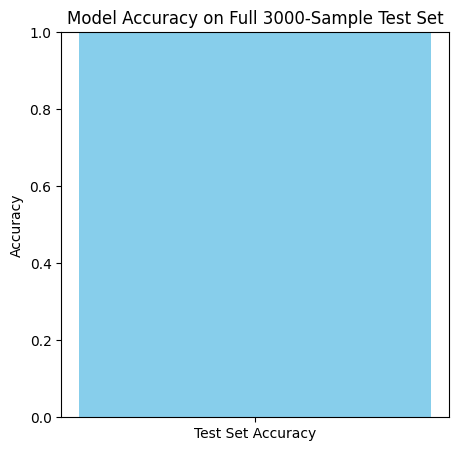

In [72]:
# accuracy as a bar

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(5,5))
plt.bar(["Test Set Accuracy"], [accuracy_full], color='skyblue')
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy on Full 3000-Sample Test Set")
plt.show()